In [44]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

Doing work for the preprocessing and looking at how clean the data is

In [45]:
path = r"all_reviews.csv"
path_pq = r"steam_reviews.parquet"

con = duckdb.connect()

df = con.execute(f"""
SELECT *
FROM read_csv_auto('{path}')
LIMIT 4
""").df()

print(df)

con.execute(f"""
DESCRIBE SELECT * FROM read_csv_auto('{path}')
""").fetchall()

   recommendationid  appid            game     author_steamid  \
0         148919893     10  Counter-Strike  76561199036724879   
1         148919350     10  Counter-Strike  76561198826729322   
2         148913051     10  Counter-Strike  76561199101237625   
3         148912714     10  Counter-Strike  76561198347582422   

   author_num_games_owned  author_num_reviews  author_playtime_forever  \
0                       0                   3                      197   
1                       0                  21                      441   
2                       7                   1                     1440   
3                      11                   4                     1636   

   author_playtime_last_two_weeks  author_playtime_at_review  \
0                             197                        197   
1                              37                        441   
2                            1440                       1313   
3                              83              

[('recommendationid', 'BIGINT', 'YES', None, None, None),
 ('appid', 'BIGINT', 'YES', None, None, None),
 ('game', 'VARCHAR', 'YES', None, None, None),
 ('author_steamid', 'BIGINT', 'YES', None, None, None),
 ('author_num_games_owned', 'BIGINT', 'YES', None, None, None),
 ('author_num_reviews', 'BIGINT', 'YES', None, None, None),
 ('author_playtime_forever', 'BIGINT', 'YES', None, None, None),
 ('author_playtime_last_two_weeks', 'BIGINT', 'YES', None, None, None),
 ('author_playtime_at_review', 'BIGINT', 'YES', None, None, None),
 ('author_last_played', 'BIGINT', 'YES', None, None, None),
 ('language', 'VARCHAR', 'YES', None, None, None),
 ('review', 'VARCHAR', 'YES', None, None, None),
 ('timestamp_created', 'BIGINT', 'YES', None, None, None),
 ('timestamp_updated', 'BIGINT', 'YES', None, None, None),
 ('voted_up', 'BIGINT', 'YES', None, None, None),
 ('votes_up', 'BIGINT', 'YES', None, None, None),
 ('votes_funny', 'BIGINT', 'YES', None, None, None),
 ('weighted_vote_score', 'DOUBLE'

In [46]:
sample_df = con.execute(f"""
        SELECT *
        FROM parquet_scan('{path_pq}')
        USING SAMPLE 0.5%
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [47]:
print(con.execute("""
SELECT voted_up, COUNT(*) 
FROM parquet_scan(?)
GROUP BY voted_up
""", [path_pq]).df())



   voted_up  count_star()
0     False      16412862
1      True      97470855


In [48]:
pos = 97470855
neg = 16412862
print(f"pct of positive reviews = {round((pos / (pos + neg)), 4)}")

pct of positive reviews = 0.8559


Looking at the variable that shows whether someone left a review with an upvote or downvote it seems that there were many more positive reviews than negative with there being 86% positive reviews in the data set. This makes sense as people are much more likely to go in and leave a positive review for a game they like than someone is who didn't like it as people who don't like it will probably just stop playing. Only people who really hated the game or had major issues usually leave a negative review. This is important though to think about as this is unbalanced data so need to account for this. Some ideas for what to do when doing the analysis is going month by month and looking at games specifically that release with a lot of negative reviews or have spikes of negative reviews to see how the games respond to this.

In [49]:
df_time_check = con.execute("""
SELECT 
    MIN(timestamp_created) AS min_time,
    MAX(timestamp_created) AS max_time
FROM parquet_scan(?)
""", [path_pq]).df()

print(df_time_check)

                   min_time                  max_time
0 2010-10-15 15:24:52-07:00 2023-11-03 09:16:25-07:00


The timeframe of the data set seems really good as it has data from 2010 until 2023.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

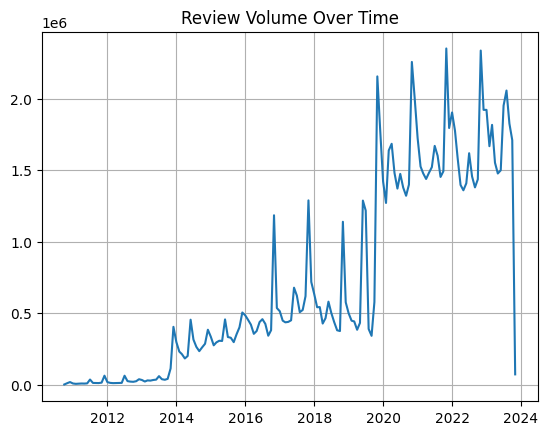

In [50]:
df_reviews_time = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    COUNT(*) AS review_count
FROM parquet_scan(?)
GROUP BY month
ORDER BY month
""", [path_pq]).df()

plt.plot(df_reviews_time["month"], df_reviews_time["review_count"])
plt.title("Review Volume Over Time")
plt.grid(True)
plt.show()

Review volume looks accurate with increasing steady over time until a huge spike when covid started as this makes sense since a ton of people started playing video games in this time. There is a sudden drop at the end of the data set which is a little weird so might want to cut off right before then.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

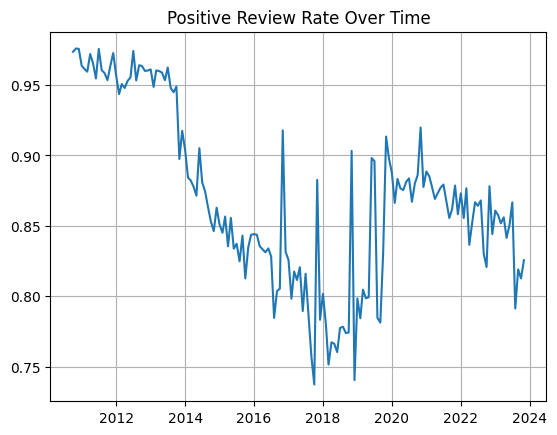

In [51]:
df_sentiment_time = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    AVG(CAST(voted_up AS INT)) AS positive_rate
FROM parquet_scan(?)
GROUP BY month
ORDER BY month
""", [path_pq]).df()

plt.plot(df_sentiment_time["month"], df_sentiment_time["positive_rate"])
plt.title("Positive Review Rate Over Time")
plt.grid(True)
plt.show()

This graph makes a lot of sense as at the start of the data set the volume of reviews was much lower than later years so it was mostly just people who were big fans of games giving reviews until gaming became more mainstreamed later on which is why the positive review rate drops over time but stabilizes after review volume also stabilized.

In [52]:
null_check = con.execute("""
SELECT 
    COUNT(*) AS total_rows,
    SUM(timestamp_created IS NULL) AS null_timestamps,
    SUM(voted_up IS NULL) AS null_sentiment,
    SUM(appid IS NULL) AS null_appid
FROM parquet_scan(?)
""", [path_pq]).df()

print(null_check)

   total_rows  null_timestamps  null_sentiment  null_appid
0   113883717              0.0             0.0         0.0


This is great because we do not have any null values in our most important values so we do not have to deal with any decisions regarding null values.

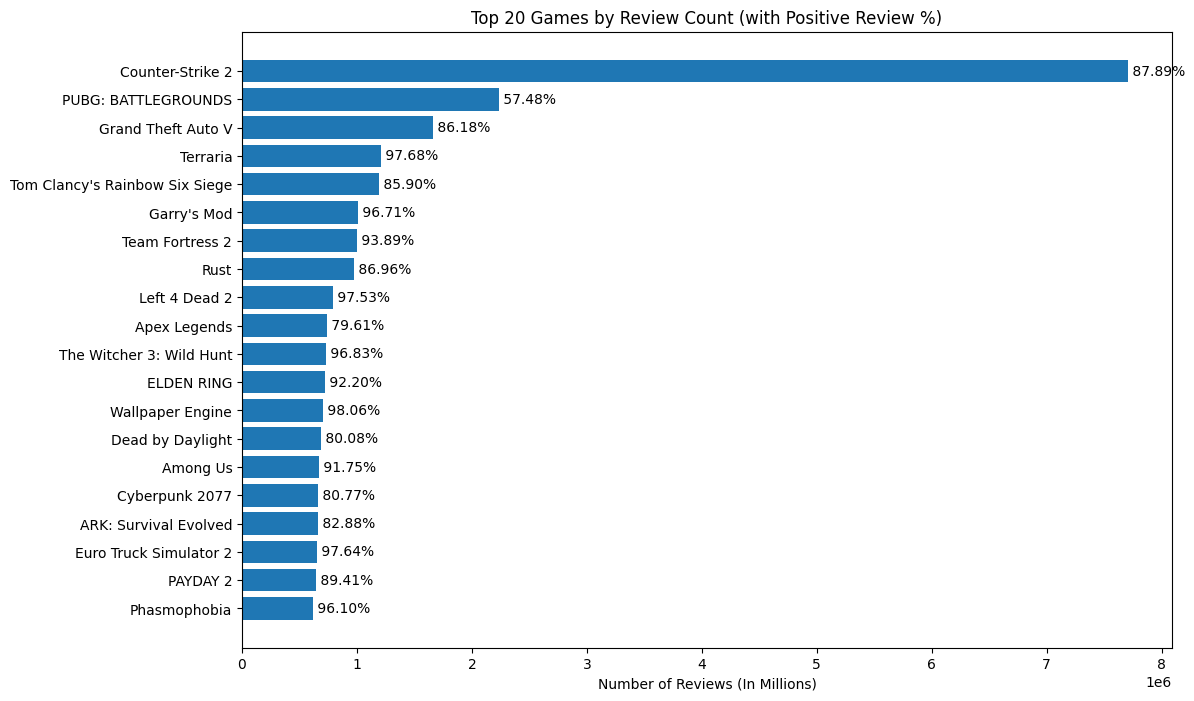

In [58]:
top_games = con.execute("""
    SELECT game, COUNT(*) AS total_reviews, AVG(CAST(voted_up AS INT)) AS positive_rate_pct
    FROM parquet_scan(?)
    GROUP BY game
    ORDER BY total_reviews DESC
    LIMIT 20
    """,
    [path_pq]).df()

plt.figure(figsize=(12, 8))
plt.barh(top_games["game"], top_games["total_reviews"])
plt.xlabel("Number of Reviews (In Millions)")
plt.title("Top 20 Games by Review Count (with Positive Review %)")
plt.gca().invert_yaxis()

for i, (count, pct) in enumerate(zip(top_games["total_reviews"], top_games["positive_rate_pct"])):
    plt.text(
        count,
        i,
        f" {pct:.2%}", 
        va="center"
    )
plt.show()


The dataset is highly imbalanced across games, with a small number of popular titles (Counter-Strike 2, PUBG, and Grand Theft Auto V) contributing millions of reviews each. This dominance suggests that aggregated sentiment trends over time may primarily reflect the review patterns of a few high-engagement games rather than the broader Steam ecosystem. As a result, analyzing sentiment at the individual game level or by game review count groups may provide more accurate insights into developer responsiveness and sentiment evolution.

In [54]:
sample_df["author_playtime_forever"].describe()

count    6.057700e+05
mean     1.377480e+04
std      4.037525e+04
min      0.000000e+00
25%      5.950000e+02
50%      2.122000e+03
75%      8.421000e+03
max      4.990477e+06
Name: author_playtime_forever, dtype: float64

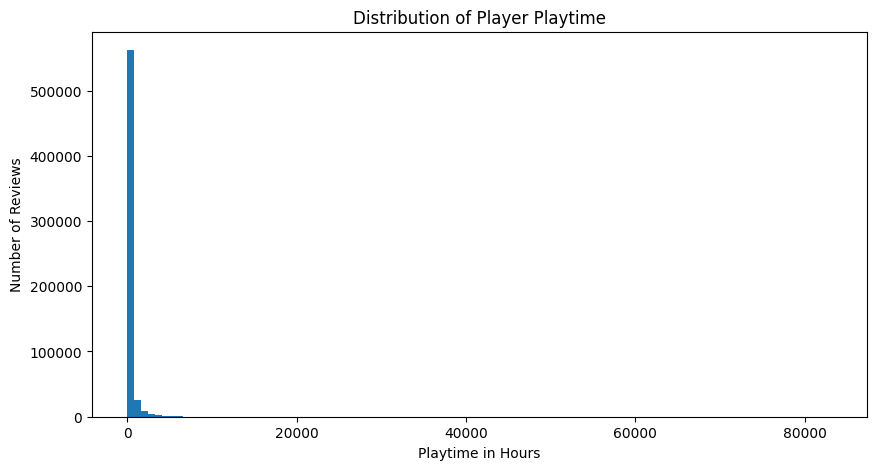

In [55]:
playtime_hours = sample_df["author_playtime_forever"] / 60

plt.figure(figsize=(10,5))
plt.hist(playtime_hours, bins=100)
plt.xlabel("Playtime in Hours")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Player Playtime")
plt.show()

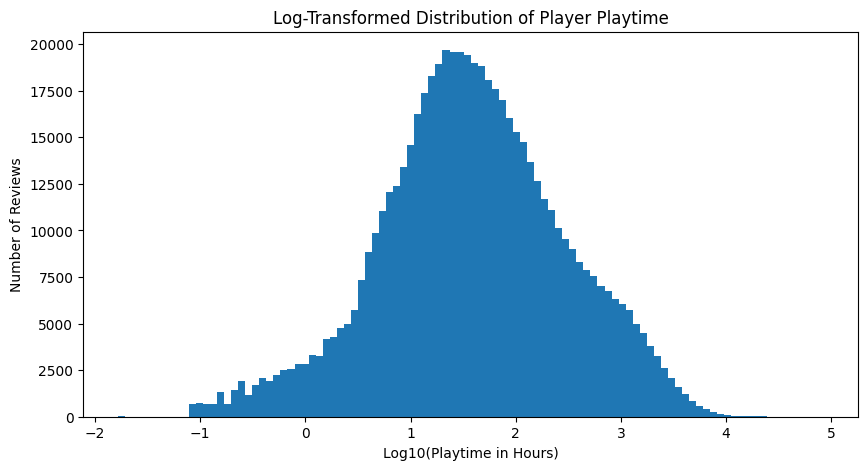

In [56]:
playtime_hours = sample_df["author_playtime_forever"] / 60
playtime_hours = playtime_hours[playtime_hours > 0]
log_playtime = np.log10(playtime_hours)

plt.figure(figsize=(10, 5))
plt.hist(log_playtime, bins=100)
plt.xlabel("Log10(Playtime in Hours)")
plt.ylabel("Number of Reviews")
plt.title("Log-Transformed Distribution of Player Playtime")
plt.show()

The distribution from the random sample of the dataset is of player playtime which is extremely right skewed with a heavy tail and a large number of near zero values. This makes sense as on average people play games casually but some people have extremely high video game playtime hours like people who are just addicted or those who have made a career out of video games. Also, some people "afk" in a game which is where you leave the game on for some reason that depends on what the game is so these people would have extremely high game playtime hours as even though they aren't actually playing steam records these users as still playing.

In [57]:
(sample_df["author_playtime_forever"] == 0).mean()

np.float64(0.019971276226950822)

Just did this to check if there were a large amount of reviews with people that had 0 playtime minutes but this is a very small percent (< 1%) so this isn't concerning for the analysis.

In [66]:
lang_dist = con.execute("""
SELECT language, COUNT(*) AS count_lang
FROM parquet_scan(?)
GROUP BY language
ORDER BY count_lang DESC
LIMIT 10
""", [path_pq]).df()

lang_dist["percent"] = (
    lang_dist["count_lang"] / lang_dist["count_lang"].sum()
) * 100

print(lang_dist)

lang_pos_rate = con.execute("""
SELECT 
    language,
    AVG(CAST(voted_up AS INT)) AS positive_rate,
    COUNT(*) AS n
FROM parquet_scan(?)
GROUP BY language
ORDER BY n DESC
LIMIT 10
""", [path_pq]).df()

print(lang_pos_rate)



    language  count_lang    percent
0    english    51544612  48.355086
1   schinese    17589884  16.501441
2    russian    12896431  12.098413
3    spanish     4837434   4.538099
4  brazilian     4713067   4.421427
5     german     3853271   3.614835
6    turkish     3406605   3.195808
7     polish     2859445   2.682506
8     french     2614302   2.452532
9    koreana     2281000   2.139854
    language  positive_rate         n
0    english       0.860040  51544612
1   schinese       0.798021  17589884
2    russian       0.860690  12896431
3    spanish       0.908259   4837434
4  brazilian       0.915468   4713067
5     german       0.846601   3853271
6    turkish       0.868414   3406605
7     polish       0.902445   2859445
8     french       0.862820   2614302
9    koreana       0.825023   2281000


Found that there is roughly only 48% of reviews in the data set are in english. This could be problematic because to look at sentiment over time, cultural differences in review behavior may influence the overall sentiment trends independently of actual game improvements. Also looking at the positive ratings of each different language there are big differences between the languages. So, I will only look at english reviews to try and limit this outside variation as much as possible when I am doing my analysis so cultural differences or game versions by different government restrictions do not affect my results.

In [69]:
edit_ratio = con.execute("""
SELECT 
    AVG(CASE 
        WHEN timestamp_updated > timestamp_created THEN 1 
        ELSE 0 
    END) AS edited_review_ratio
FROM parquet_scan(?)
""", [path_pq]).df()

print(edit_ratio)

edit_sentiment = con.execute("""
SELECT 
    CASE 
        WHEN timestamp_updated > timestamp_created THEN 'Edited'
        ELSE 'Not Edited'
    END AS review_type,
    AVG(CAST(voted_up AS INT)) AS positive_rate,
    COUNT(*) AS n
FROM parquet_scan(?)
GROUP BY review_type
""", [path_pq]).df()

print(edit_sentiment)


   edited_review_ratio
0              0.12019
  review_type  positive_rate          n
0  Not Edited       0.868809  100196026
1      Edited       0.761241   13687691


Looking at review edit behavior shows that approximately 12% of reviews were edited after their initial posting. The edited reviews show a significantly lower positive rate about 76.1% compared to non-edited reviews about 86.9%. The dataset records only the final state of each review, meaning that edited reviews overwrite their original sentiment rather than creating new entries. So, the sentiment variable (voted_up) reflects the reviewer’s most recent opinion, while the timestamp corresponds to the original review date. This introduces a confounding limitation, as sentiment trends over time may partially reflect revised opinions rather than purely initial player reactions, but I think it would be better to keep edited reviews because they capture meaningful sentiment and player responses to updates and game improvements. This is just going to be something I will have to pay attention to in the analysis and try to come up with a way to affectively handle it without removing it entirely.

In [70]:
unique_games = con.execute("""
SELECT COUNT(DISTINCT appid) AS num_games
FROM parquet_scan(?)
""", [path_pq]).df()

print(unique_games)


   num_games
0     105893


Just did a quick check to see the amount of games that were in the data set to make sure the reviews didn't only represent some games. Although with there being 100,000+ games in this dataset it is safe to say that this is pretty representative of Steam games overall as it has tons of smaller games in the dataset.

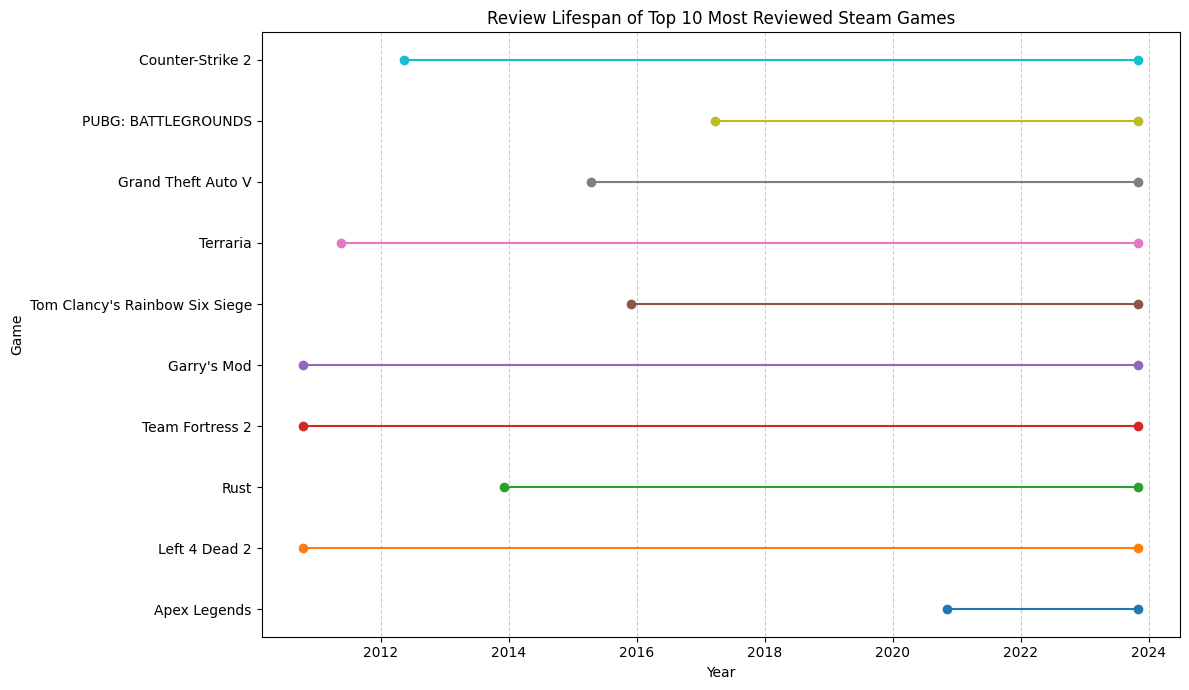

In [72]:
game_time_span = con.execute("""
SELECT 
    game,
    MIN(timestamp_created) AS first_review,
    MAX(timestamp_created) AS last_review,
    COUNT(*) AS total_reviews
FROM parquet_scan(?)
GROUP BY game
ORDER BY total_reviews DESC
LIMIT 10
""", [path_pq]).df()


game_time_span = game_time_span.sort_values("total_reviews", ascending=True)

plt.figure(figsize=(12, 7))

for i, row in game_time_span.iterrows():
    plt.plot(
        [row["first_review"], row["last_review"]],
        [row["game"], row["game"]],
        marker="o"
    )

plt.xlabel("Year")
plt.ylabel("Game")
plt.title("Review Lifespan of Top 10 Most Reviewed Steam Games")
plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


A lifespan timeline of the top 10 most reviewed games shows that many titles maintain active review activity for over a decade capturing reviews from there release until the end of the dataset. Games such as Terraria, Team Fortress 2, and Counter-Strike exhibit continuous engagement from early 2010s through 2023, showing that the dataset captures actual long-term player sentiment rather than just short-lived review bursts. This supports the validity of my research hypothesis, as long-term review coverage is necessary to analyze how player sentiment evolves in response to game updates, developer feedback, and lifecycle changes.